<a href="https://colab.research.google.com/github/Ouzr0107/pytorch_ex/blob/main/extras/exercises/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [5]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

import torch
import torchvision

assert (
    int(torch.__version__.split(".")[1]) >= 12
    or int(torch.__version__.split(".")[0]) > 1
), "torch version should be 1.12+"
assert (
    int(torchvision.__version__.split(".")[1]) >= 13
), "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [6]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2626036c830>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

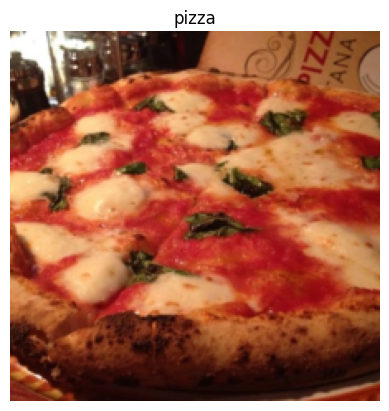

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [24]:
from timeit import default_timer as timer

loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_transforms = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

pretrained_vit = torchvision.models.vit_b_16()
# Modify the classifier head to match the saved model structure
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))
pretrained_vit.load_state_dict(
    torch.load("models/pretrained_vit_pizza_steak_sushi.pth")
)

device = "cpu"

pretrained_vit.to(device)

time = timer()

engine.test_step(
    model=pretrained_vit, dataloader=test_dataloader, loss_fn=loss_fn, device=device
)
print(f"Time taken: {timer() - time:.4f} seconds")

device = "cuda"

pretrained_vit.to(device)

time = timer()

engine.test_step(
    model=pretrained_vit, dataloader=test_dataloader, loss_fn=loss_fn, device=device
)

print(f"Time taken: {timer() - time:.4f} seconds")

Time taken: 34.5111 seconds
Time taken: 8.8430 seconds


In [25]:
pretrained_enet_transforms = (
    torchvision.models.EfficientNet_B1_Weights.DEFAULT.transforms()
)

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_enet_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

pretrained_enet = torchvision.models.efficientnet_b1()

pretrained_enet.classifier[1] = nn.Linear(
    in_features=1280, out_features=len(class_names)  # specific to EfficientNet_B1
)
pretrained_enet.load_state_dict(torch.load("models/EfficientNet_B1_20_percent.pth"))

device = "cpu"

pretrained_enet.to(device)

time = timer()

engine.test_step(
    model=pretrained_enet, dataloader=test_dataloader, loss_fn=loss_fn, device=device
)

print(f"Time taken: {timer() - time:.4f} seconds")

device = "cuda"

pretrained_enet.to(device)

time = timer()

engine.test_step(
    model=pretrained_enet, dataloader=test_dataloader, loss_fn=loss_fn, device=device
)

print(f"Time taken: {timer() - time:.4f} seconds")

Time taken: 10.4688 seconds
Time taken: 7.8284 seconds


## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [8]:
def create_vit_model(num_classes: int):
    """Creates a Vision Transformer (ViT) model with a specified number of output classes.

    Args:
        num_classes (int): The number of output classes for the model.

    Returns:
        torch.nn.Module: A Vision Transformer model with the specified number of output classes.
    """
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    model.heads = nn.Linear(in_features=768, out_features=num_classes)
    return model, transforms

In [9]:
vit_food101, vit_food101_transforms = create_vit_model(num_classes=101)

In [10]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=vit_food101_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_food101_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)



In [11]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [13]:
def split_dataset(dataset: torch.utils.data.Dataset, split: float = 0.8):
    """Splits a PyTorch dataset into training and testing sets.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to split.
        split (float, optional): The proportion of the dataset to use for training. Defaults to 0.8.

    Returns:
        tuple: A tuple containing the training and testing datasets.
    """
    length_1 = int(len(dataset) * split)
    length_2 = len(dataset) - length_1
    random_split_1, random_split_2 = torch.utils.data.random_split(
        dataset, [length_1, length_2]
    )
    return random_split_1, random_split_2

In [14]:
train_data_food101_20_percent, _ = split_dataset(train_data, split=0.2)
test_data_food101_20_percent, _ = split_dataset(test_data, split=0.2)

In [15]:
import os

BATCH_SIZE = 32

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    dataset=train_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    dataset=test_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count(),
)

In [16]:
optimizer = torch.optim.Adam(vit_food101.parameters(), lr=0.003)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()

vit_food101_results = engine.train(
    model=vit_food101,
    train_dataloader=train_dataloader_food101_20_percent,
    test_dataloader=test_dataloader_food101_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4637 | train_acc: 0.5191 | test_loss: 2.0258 | test_acc: 0.6387


KeyboardInterrupt: 

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [ ]:
# TODO: your code

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [ ]:
# TODO: your code

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

In [ ]:
# TODO: your answer to the above

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

In [ ]:
# TODO: your answer to the above

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [ ]:
# TODO: your code